# Multivariate LSTM forecasting on stock market price
Variables used along date from GE<br>
<ul>
<li> 'Open' </li><li>'High' </li><li>'Low' </li><li>'Close'</li> <li>'Adj Close'</li>
</ul>
These values in stock market has no huge gap but are different with a little gap in values!

In [218]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importing and scaling data-set

In [219]:
df = pd.read_csv('GE.csv') # data frame 
print(df.shape)
df.head()

(504, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-09-03,64.800003,67.120003,64.639999,66.639999,66.072899,8456113
1,2019-09-04,67.279999,70.959999,67.199997,70.400002,69.800903,11706713
2,2019-09-05,71.919998,73.839996,70.400002,70.480003,69.880234,10861388
3,2019-09-06,70.559998,70.559998,68.559998,69.680000,69.087021,5355775
4,2019-09-09,70.000000,72.400002,69.839996,71.680000,71.070007,6245063


In [220]:
train_dates = pd.to_datetime(df['Date']) # seprate for future ploting
cols = list(df)[1:6] # variables for training
print(cols)
print(train_dates.tail(1))

['Open', 'High', 'Low', 'Close', 'Adj Close']
503   2021-08-31
Name: Date, dtype: datetime64[ns]


(504, 5)

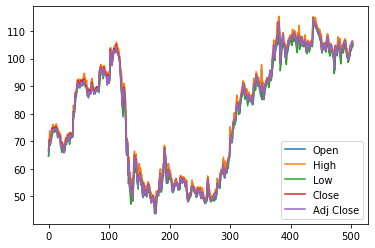

In [221]:
df_for_training = df[cols].astype(float)
df_for_plot = df_for_training.tail(5000)
df_for_plot.plot.line()
df_for_training.shape

# 2. Scaling data using StanddardScaler

In [222]:
# LSTM uses tanh and sigmoid sensitive to magnitude/values so normalized needed
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_training_scaled.shape

(504, 5)

### Generating time series using fixed window size

In [223]:
trainX = []
trainY = []

feature  = 5 # number of days wants to predict in future
look = 6  # no. of past days you want to  use for predicting future

for i in range(look, len(df_for_training_scaled) - feature +1):
    trainX.append(df_for_training_scaled[i - look:i, 0:df_for_training.shape[1]]) # not include i --> number of steps
    trainY.append(df_for_training_scaled[i, 0:df_for_training.shape[1]]) # shape --> no of features/variable

trainX = np.array(trainX)
trainY = np.array(trainY)
print(trainX[2]) 
trainY[1] # next predicted values of trainX[0]

[[-0.40310844 -0.37430597 -0.41037357 -0.46729214 -0.4818422 ]
 [-0.46702214 -0.52806336 -0.49707665 -0.50479233 -0.51897169]
 [-0.49333945 -0.44180898 -0.43676169 -0.4110422  -0.42615014]
 [-0.43318543 -0.35930487 -0.3726769  -0.34354197 -0.35931862]
 [-0.34295442 -0.32555355 -0.31236156 -0.26104215 -0.27763611]
 [-0.24896368 -0.26555031 -0.25204656 -0.29854196 -0.31476452]]


array([-0.24896368, -0.26555031, -0.25204656, -0.29854196, -0.31476452])

# 3. Design Model

In [224]:
#model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(look, feature) ,return_sequences= True ))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 6, 64)             17920     
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 165       
Total params: 30,501
Trainable params: 30,501
Non-trainable params: 0
_________________________________________________________________


In [225]:
history = model.fit(trainX, trainY, batch_size=16, epochs=20, verbose=1, validation_split=0.1 )

Epoch 1/20
28/28 [==============================] - 0s 12ms/step - loss: 0.7314 - val_loss: 0.1677
Epoch 2/20
28/28 [==============================] - 0s 5ms/step - loss: 0.2073 - val_loss: 0.0554
Epoch 3/20
28/28 [==============================] - 0s 5ms/step - loss: 0.1465 - val_loss: 0.0510
Epoch 4/20
28/28 [==============================] - 0s 5ms/step - loss: 0.1200 - val_loss: 0.0218
Epoch 5/20
28/28 [==============================] - 0s 5ms/step - loss: 0.1089 - val_loss: 0.0285
Epoch 6/20
28/28 [==============================] - 0s 5ms/step - loss: 0.1017 - val_loss: 0.0405
Epoch 7/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0868 - val_loss: 0.0130
Epoch 8/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0862 - val_loss: 0.0120
Epoch 9/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0818 - val_loss: 0.0118
Epoch 10/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0763 - val_loss: 0.0106
Epoch 11/20
28/28 

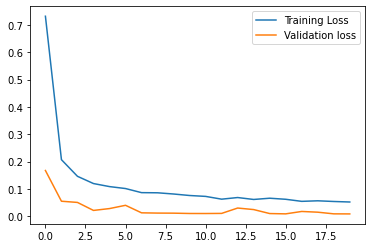

In [226]:
#ploting 
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

# 4. Prediction part

In [229]:
# starting from last day in training date and predict future
n_future = 90
forecast_date_period = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist() #creates next dates
forecast = model.predict(trainX[-n_future:]) # last 90 days training data
forecast_copy = np.repeat(forecast,1, axis=-1) # 1 --> no of times repeat

print(forecast_copy[1])
y_predict = scaler.inverse_transform(forecast_copy)[:,0:5] # (:) --> all rows, 0:5 --> five columns (0-4)
print(y_predict[:,1]) # alll rows in first column 

[1.1483834 1.1542253 1.1773647 1.1857755 1.1757032]
[107.959564 106.447075 105.99509  106.98563  108.14781  109.391655
 108.415276 107.252754 106.34819  106.02697  106.97092  106.73143
 106.579414 106.38561  106.55326  107.34479  106.534615 105.19599
 104.38608  105.313446 106.07403  105.91655  105.37681  105.202385
 105.84108  106.35937  106.373024 106.83426  110.273544 112.407394
 113.53103  113.34339  112.81506  111.81562  111.09789  110.696175
 109.90821  109.44704  109.26325  108.82081  108.303535 107.98567
 106.443306 104.36675  104.57654  104.88745  105.16378  105.519745
 105.90323  105.34453  105.43368  106.48192  107.86432  108.15573
 106.46246  104.97509  103.72487  104.67005  105.27666  105.2195
 104.474396 103.61266  102.79955   99.72425  100.396484 102.21588
 103.15561  103.37295  103.41476  104.706955 105.70799  106.454094
 105.791016 104.39724  103.13104  103.14391  103.8039   104.75013
 104.78503  105.58475  106.17256  106.916374 106.72456  105.45171
 103.81805  102.960

In [230]:
forecast_dates = pd.to_datetime([i.date() for i in forecast_date_period])
forecast_dates[1]

Timestamp('2021-09-01 00:00:00')

### Take everything into Data Frame

#### (A) Forecasting Data Frame

In [231]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 
                            'Open':np.array(y_predict[:,0]), 
                            'High':np.array(y_predict[:,1]),
                           'Low': np.array(y_predict[:,2]),
                           'Close': np.array(y_predict[:,3]),
                           'Adj Close': np.array(y_predict[:,4])})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

#### (B) Origional data Frame

In [232]:
origional = df[['Date','Open','High', 'Low', 'Close', 'Adj Close']] # takes all origional data
origional['Date']  = pd.to_datetime(origional['Date'])

print(origional.tail(5))
print(df_forecast.head(5))

          Date        Open        High         Low       Close   Adj Close
499 2021-08-25  103.360001  105.129997  102.550003  104.699997  104.699997
500 2021-08-26  104.459999  104.620003  102.839996  103.379997  103.379997
501 2021-08-27  103.900002  106.150002  103.900002  106.089996  106.089996
502 2021-08-30  106.330002  106.459999  104.800003  105.190002  105.190002
503 2021-08-31  104.940002  106.360001  104.459999  105.410004  105.410004
        Date        Open        High         Low       Close   Adj Close
0 2021-08-31  106.315582  107.959564  105.490791  107.192490  106.602043
1 2021-09-01  104.933716  106.447075  104.094826  105.745399  105.291077
2 2021-09-02  104.640923  105.995087  103.816803  105.456078  104.874077
3 2021-09-03  105.408188  106.985626  104.645287  106.317429  105.601601
4 2021-09-04  106.250282  108.147812  105.404625  107.185707  106.529358


<ipython-input-232-efd15406e511>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  origional['Date']  = pd.to_datetime(origional['Date'])


### 1. Open price Prediction

<AxesSubplot:xlabel='Date', ylabel='Open'>

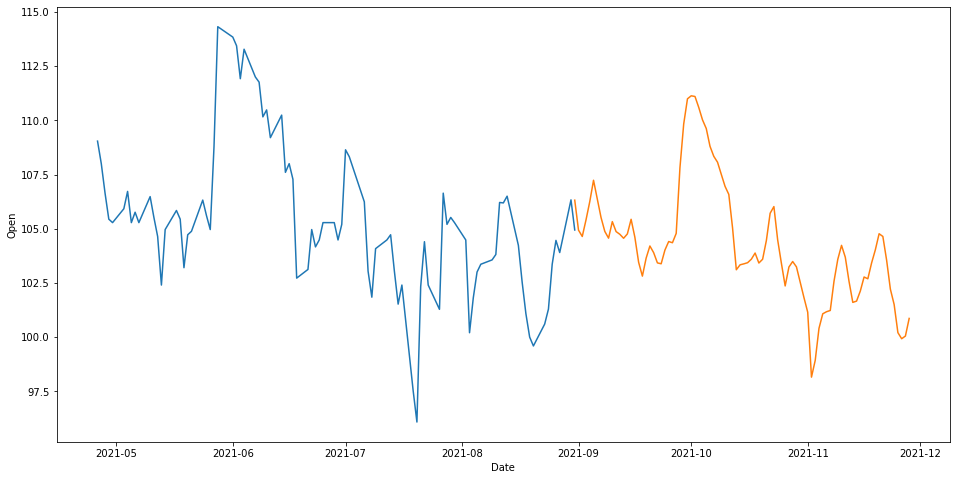

In [233]:
plt.figure(figsize=(16,8))
sns.lineplot(data= origional.tail(90), x='Date', y='Open')
sns.lineplot(data = df_forecast, x='Date', y= 'Open')

### 2.Close price prediction

<AxesSubplot:xlabel='Date', ylabel='Close'>

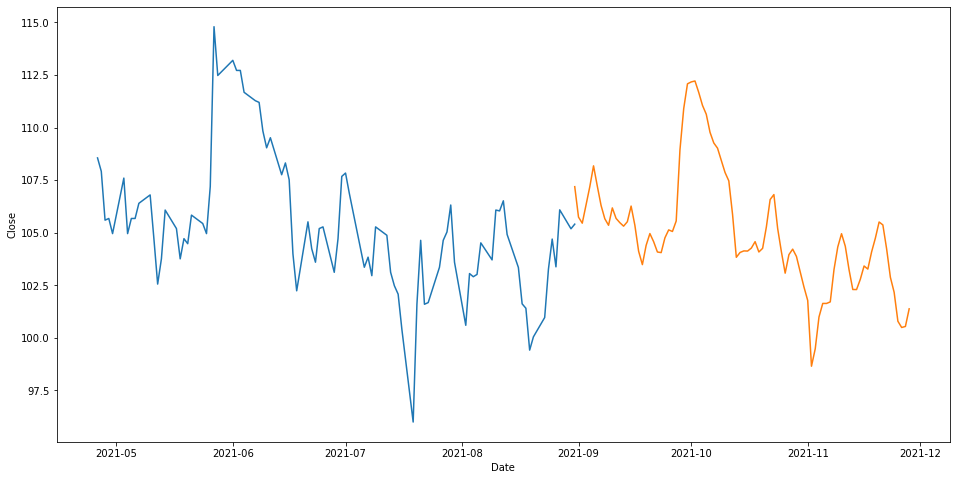

In [234]:
plt.figure(figsize=(16,8))
sns.lineplot(data= origional.tail(90), x='Date', y='Close')
sns.lineplot(data = df_forecast, x='Date', y= 'Close')

### 3. High price prediction

<AxesSubplot:xlabel='Date', ylabel='High'>

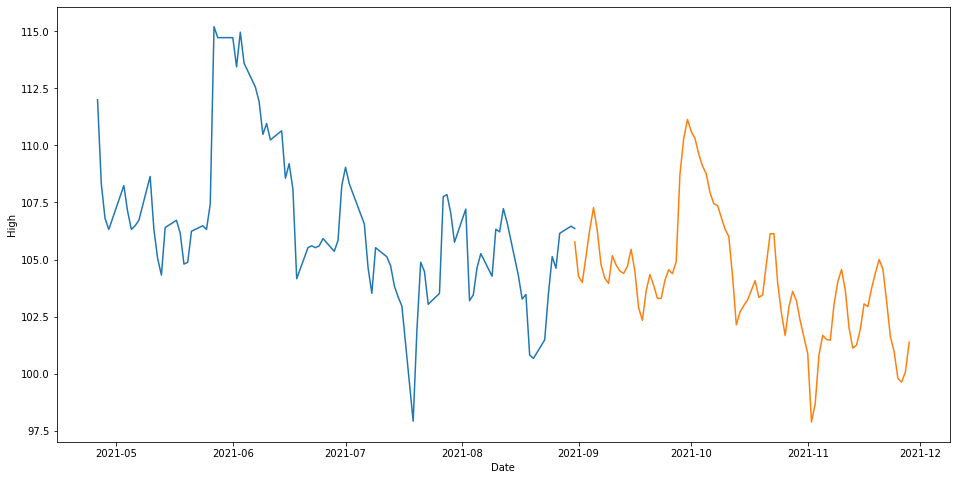

In [217]:
plt.figure(figsize=(16,8))
sns.lineplot(data= origional.tail(90), x='Date', y='High')
sns.lineplot(data = df_forecast, x='Date', y= 'High')

# Refferences

Dataset: https://finance.yahoo.com/quote/GE/history?ltr=1 <br>
Video: https://www.youtube.com/watch?v=tepxdcepTbY <br>
LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/